In [5]:
!pip install kaggle

In [6]:
!pip install plotly

In [7]:
from transformers import pipeline
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import re
from datetime import datetime

In [8]:
# ID file
file_id = "1-5_JXOnscS2zN1nEgNVKJX5wFL4uLb1L"
download_link = f"https://drive.google.com/uc?id={file_id}"

# dowload the file csv from Google drive
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

In [9]:
# data wraining
df.set_index('Unnamed: 0', inplace=True)
df.index.name ="ID"

In [10]:
df.head()

,time,comment
ID,,
0,0:03,was uppp everyone
1,0:05,this is it
2,0:07,bobchamp
3,0:07,Omg Im so excited for this
4,0:07,french here


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16130 entries, 0 to 16129
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   time     16130 non-null  object
 1   comment  16130 non-null  object
dtypes: object(2)
memory usage: 378.0+ KB


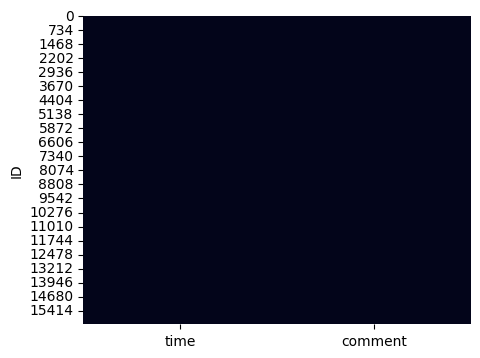

In [12]:
# there don´t present data null
plt.figure(figsize=(5, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [13]:
# Load analitic model for feelings
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
# Create function for get polarity in comments
def obtener_polaridad(comentario):
    resultado = classifier(comentario)
    return resultado[0]['label']

In [15]:
# apply the function to each comment of dataframe.
df['polarity'] = df['comment'].apply(obtener_polaridad)

In [16]:
df

,time,comment,polarity
ID,,,
0,0:03,was uppp everyone,1 star
1,0:05,this is it,5 stars
2,0:07,bobchamp,4 stars
3,0:07,Omg Im so excited for this,1 star
4,0:07,french here,3 stars
...,...,...,...
16125,2:11:41,R I P David Bowie,5 stars
16126,2:11:41,_perfect_effect_ nice to meet you,5 stars
16127,2:11:41,its finished,4 stars


In [17]:
# df de contigencia
df_origin = df.copy()

In [74]:
df=df_origin.copy()

In [76]:
df.head(5)

,time,comment,polarity
ID,,,
0,0:03,was uppp everyone,1 star
1,0:05,this is it,5 stars
2,0:07,bobchamp,4 stars
3,0:07,Omg Im so excited for this,1 star
4,0:07,french here,3 stars


In [77]:
# function for create regular expression
def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    return int(numeros[0]) if numeros else None
df['score'] = df['polarity'].apply(extraer_numeros)

In [78]:
df.head(5)

,time,comment,polarity,score
ID,,,,
0,0:03,was uppp everyone,1 star,1
1,0:05,this is it,5 stars,5
2,0:07,bobchamp,4 stars,4
3,0:07,Omg Im so excited for this,1 star,1
4,0:07,french here,3 stars,3


In [51]:
def positive(puntuacion):
    return 1 if puntuacion in [4, 5] else 0
df['POSITIVE'] = df['score'].apply(positive)
df['CUMULATIVE_POSITIVE'] = df['POSITIVE'].cumsum()


def neutral(puntuacion):
    return 1 if puntuacion in [3] else 0
df['NEUTRAL'] = df['score'].apply(neutral)
df['CUMULATIVE_NEUTRAL'] = df['NEUTRAL'].cumsum()


def negative(puntuacion):
    return 1 if puntuacion in [1, 2] else 0
df['NEGATIVE'] = df['score'].apply(negative)
df['CUMULATIVE_NEGATIVE'] = df['NEGATIVE'].cumsum()

In [23]:
df1=df[['time', 'POSITIVE', 'NEUTRAL', 'NEGATIVE']]

In [52]:
df['time'] = df['time'].astype(str)

# Ahora puedes realizar el groupby
grouped_df = df.groupby('time').agg({
    'POSITIVE': 'sum',
    'NEUTRAL': 'sum',
    'NEGATIVE': 'sum'
}).reset_index()

In [53]:
grouped_df

,time,POSITIVE,NEUTRAL,NEGATIVE
0,0:03,0,0,1
1,0:05,1,0,0
2,0:07,1,1,1
3,0:08,1,0,0
4,0:09,0,0,1
...,...,...,...,...
6446,9:53,2,0,1
6447,9:54,0,0,2
6448,9:57,1,0,1
6449,9:58,2,0,0


In [67]:
grouped_df['CUMULATIVE_POSITIVE'] = grouped_df['POSITIVE'].cumsum()
grouped_df['CUMULATIVE_NEUTRAL'] = grouped_df['NEUTRAL'].cumsum()
grouped_df['CUMULATIVE_NEGATIVE'] = grouped_df['NEGATIVE'].cumsum()

In [68]:
grouped_df.head()

,time,POSITIVE,NEUTRAL,NEGATIVE,CUMULATIVE_POSITIVE,CUMULATIVE_NEUTRAL,CUMULATIVE_NEGATIVE
0,0:03,0,0,1,0,0,1
1,0:05,1,0,0,1,0,1
2,0:07,1,1,1,2,1,2
3,0:08,1,0,0,3,1,2
4,0:09,0,0,1,3,1,3


In [70]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6451 entries, 0 to 6450
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   time                 6451 non-null   object
 1   POSITIVE             6451 non-null   int64 
 2   NEUTRAL              6451 non-null   int64 
 3   NEGATIVE             6451 non-null   int64 
 4   CUMULATIVE_POSITIVE  6451 non-null   int64 
 5   CUMULATIVE_NEUTRAL   6451 non-null   int64 
 6   CUMULATIVE_NEGATIVE  6451 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 352.9+ KB


In [56]:
df_positive = grouped_df[['time', 'CUMULATIVE_POSITIVE']]
df_positive = df_positive.rename(columns={'CUMULATIVE_POSITIVE': 'y'})

In [57]:
df_neutral = grouped_df[['time', 'CUMULATIVE_NEUTRAL']]
df_neutral = df_neutral.rename(columns={'CUMULATIVE_NEUTRAL': 'y'})

In [58]:
df_negative = grouped_df[['time', 'CUMULATIVE_NEGATIVE']]
df_negative = df_negative.rename(columns={'CUMULATIVE_NEGATIVE': 'y'})

In [63]:
import pandas as pd
import plotly.express as px


# Asignar colores a cada categoría al crear los DataFrames
color_mapping = {'POSITIVE': 'green', 'NEUTRAL': 'white', 'NEGATIVE': 'red'}

df_positive['color'] = color_mapping['POSITIVE']
df_neutral['color'] = color_mapping['NEUTRAL']
df_negative['color'] = color_mapping['NEGATIVE']

# Concatenar los conjuntos de datos
df = pd.concat([df_positive, df_neutral, df_negative], keys=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# Crear el gráfico estático
fig_total = px.line(df, x='time', y='y', color='color', range_x=[0, 6], range_y=[0, 3],
                    line_dash='color', color_discrete_sequence=['green', 'white', 'red'])

# Personalizar la gráfica total
fig_total.update_layout(
    title='Trayectorias del Recorrido Total',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    height=800
)

# Mostrar el gráfico estático
fig_total.show()


In [43]:
df_positive['x'] = 1
df_positive['y'] = 1

In [45]:
df_positive['x'] = 1
df_positive['y'] = 1

,time,y,color,x
0,0:03,1,green,1
1,0:05,1,green,1
2,0:07,1,green,1
3,0:08,1,green,1
4,0:09,1,green,1


In [34]:


# Crear datos de ejemplo para el primer conjunto de puntos
df1 = pd.DataFrame({
    'Tiempo': [1, 2, 3, 4, 5],
    'x': [1, 1, 1, 1, 1],
    'y': [1, 1, 1, 1, 1],
    'Acumulado': [5, 10, 15, 20, 45]  # Agregar columna de acumulado
})

# Crear datos de ejemplo para el segundo conjunto de puntos
df2 = pd.DataFrame({
    'Tiempo': [1, 2, 3, 4, 5],
    'x': [2, 2, 2, 2, 2],
    'y': [2, 2, 2, 2, 2],
    'Acumulado': [5, 50, 100, 150, 250]  # Agregar columna de acumulado
})

# Crear datos de ejemplo para el tercer conjunto de puntos
df3 = pd.DataFrame({
    'Tiempo': [1, 2, 3, 4, 5],
    'x': [3, 3, 3, 3, 3],
    'y': [3, 3, 3, 3, 3],
    'Acumulado': [10, 20, 30, 40, 50]  # Agregar columna de acumulado
})

# Agregar columnas de colores y símbolos específicos
df1['Color'] = 'red'
df1['Symbol'] = 'circle'
df2['Color'] = 'green'
df2['Symbol'] = 'circle'
df3['Color'] = 'blue'
df3['Symbol'] = 'circle'

# Concatenar los conjuntos de datos
df = pd.concat([df1, df2, df3], keys=['Conjunto1', 'Conjunto2', 'Conjunto3'])

# Crear la gráfica animada con tamaño variable y colores personalizados
fig = px.scatter(df, x='x', y='y', animation_frame='Tiempo', size='Acumulado',
                 color='Color', range_x=[0, 4], range_y=[0, 4], size_max=250,
                 color_discrete_map={'red': 'red', 'green': 'green', 'blue': 'blue'}, symbol='Symbol', text='Acumulado')

# Personalizar la animación y el diseño
fig.update_layout(
    title='Gráfica Animada con Plotly',
    xaxis_title='Eje X',
    yaxis_title='Eje Y',
    template='plotly_dark',  # Cambiar al tema oscuro
    xaxis=dict(showgrid=False),  # Quitar la cuadrícula del eje X
    yaxis=dict(showgrid=False),  # Quitar la cuadrícula del eje Y
    height=700  # Ajustar la altura del lienzo
)

# Mostrar la gráfica
fig.show()